In [1]:
import matplotlib
matplotlib.use('qtagg')
#%matplotlib tk
%autosave 180
%load_ext autoreload
%autoreload 2

import nest_asyncio
%config Completer.use_jedi = False

#
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#
import sys

import matplotlib.pyplot as plt
import pickle
import numpy as np
import networkx as nx


Autosaving every 180 seconds


<ipython-input-1-09f05b494581>:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
################################################
############ HELPER FUNCTIONS ##################
################################################
from sklearn.manifold import Isomap
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import cKDTree
import h5py
import os


# 
def remove_duplicate_states(data):
    
    data2 = []
    data2.append(data[0])
    for k in range(1, data.shape[0], 1):
        
        if (data[k]-data[k-1]).sum(0)>1E-10:
            data2.append(data[k])
            
    data2 = np.array(data2)
    
    return data2

#
def run_pca(data):
    from sklearn.decomposition import PCA
    pca = PCA(svd_solver='full')
    X_pca = pca.fit_transform(data)
    print ("   Initial X_pca: ", X_pca.shape)
    
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    #print ("cumsum: ", cumsum)
    idx = np.where(cumsum>0.95)[0]
    
    print ("   # of comps to 95% exp variance: ", idx[0])
    return X_pca[:,:idx[0]]

#
def run_deduplication(X_pca):
    
    print ("pre duplcitaion: ", X_pca.shape)
    X_pca2 = remove_duplicate_states(X_pca)
    print ("X_pca2: ", X_pca2.shape)
    print (" % of unique states: ", round(X_pca2.shape[0]/X_pca.shape[0],2))

    return X_pca2

#
def run_addnoise(X_pca2):
    
    # add noise to prevent crashes
    noise = np.random.rand(X_pca2.shape[0], 
                           X_pca2.shape[1])*1E-3
    X_pca2 = X_pca2+noise

    return X_pca2

#
def run_binning(data, bin_size=7, sum_flag=True):
    
    # split data into bins
    idx = np.arange(0, data.shape[0], bin_size)
    d2 = np.array_split(data, idx[1:])
    
    # sum on time axis; drop last value
    if sum_flag:
        d3 = np.array(d2[:-1]).sum(1)
    else:
        d3 = np.median(np.array(d2[:-1]), axis=1)
    
    print ("   Data binned using ", bin_size, " frame bins, final size:  ", d3.shape)

    #    
    return d3

#
def knn_triage_step(pca_wf, triage_value):

    knn_triage_threshold = 100*(1-triage_value)

    if pca_wf.shape[0] > 1/triage_value:
        idx_keep = knn_triage(knn_triage_threshold, pca_wf)
        idx_keep = np.where(idx_keep==1)[0]
    else:
        idx_keep = np.arange(pca_wf.shape[0])

    return idx_keep  
 
#
def knn_triage(th, pca_wf):

    tree = cKDTree(pca_wf)
    dist, ind = tree.query(pca_wf, k=6)
    dist = np.sum(dist, 1)

    idx_keep1 = dist <= np.percentile(dist, th)
    return idx_keep1

#
def load_tracks(fname_tracks, bin_width=5):

    #
    pos_tracks = []
    idx_tracks = []
    idx_ctr = 0
    for fname_track in fname_tracks:
        with h5py.File(fname_track, 'r') as file:
            #
            pos = file['trdEval']['position_atframe'][()].squeeze()

            n_timesteps = pos.shape[0]
            #print ("# of time steps: ", pos.shape)

        # bin speed for some # of bins
        #bin_width = 5
        sum_flag = False
        pos_bin = run_binning(pos, bin_width, sum_flag)
        print ("pos bin: ", pos_bin.shape)

        #
        pos_tracks.append(pos_bin)

        # add locations of the belt realtive
        temp = np.arange(idx_ctr,idx_ctr+n_timesteps,1)
        idx_tracks.append(temp)
    
        idx_ctr+=n_timesteps
        
    return pos_tracks, idx_tracks

# 

def load_ca_bin(fname_ca, idx_track, bin_width):
    data = np.load(fname_ca).T
    print ("All [ca] data: ", data.shape)

    # select data to analyzie
    data = data[idx_track]
    print ("   Specific belt data: ", data.shape)


    # 
    data = run_binning(data, bin_width, sum_flag=True)

    #
   
    return data
    

def load_ca_bin_pca(fname_ca, idx_track, bin_width):

    data = np.load(fname_ca).T
    print ("All [ca] data: ", data.shape)

    # select data to analyzie
    data = data[idx_track]
    print ("   Specific belt data: ", data.shape)


    # 
    data = run_binning(data, bin_width, sum_flag=True)

    #
    X_pca = run_pca(data)

    #
    print ("Final data (n_timesteps, n_dimensions): ", X_pca.shape)
    
    return X_pca
    
#
# def run_isomap(session_ids, fname_tracks,bin_width):
#     for session_id,fname_track in zip(session_ids,fname_tracks):
#         idx_track = idx_tracks[session_id]

#         #
#         X_pca = load_ca_bin_pca(fname_ca, idx_track, bin_width)

#         # 
#         fname_out = fname_track.replace('.mat','_'+str(bin_width)+"bin_isomap.npy")
#         if os.path.exists(fname_out)==False:
#             print ("Running Isomap: ", X_pca.shape)
#             embedding = Isomap(n_components=3, n_jobs = -1)
#             X_isomap = embedding.fit_transform(X_pca)
#             np.save(fname_out, X_isomap)

#         else:
#             X_isomap = np.load(fname_out)

#         print ("")
        
#     print ("    DONE .... ")
    
#     return None
 
def plot_2d(X_pca, pos_track, ax1, title, n_segs, alpha=1):
    
    # 
    cmap = plt.get_cmap('viridis', n_segs)
#     print ("pos track: ", np.unique(pos_track))
#     print ('median pos_track:', np.median(pos_track))
    #
    p = ax1.scatter(X_pca[:,0],
                 X_pca[:,1],
                 #X_pca[:,2],
                 c=cmap(pos_track),
                 #cmap='viridis',
                    
                 #cmap = pos_track,
                 #edgecolor='black',
                 alpha=alpha)
    
    #ax=plt.gca() #get the current axes
#     PCM=ax1.get_children()[2] #get the mappable, the 1st and the 2nd are the x and y axes
#     plt.colorbar(PCM, ax=ax1) 

    plt.title(title)
    
    return p



def plot_3d(X_pca, pos_track, ax1, title, n_segs, alpha=1):
    
    # 
    cmap = plt.get_cmap('viridis', n_segs)
#     print ("pos track: ", np.unique(pos_track))
#     print ('median pos_track:', np.median(pos_track))
    #
    p = ax1.scatter3D(X_pca[:,0],
                 X_pca[:,1],
                 X_pca[:,2],
                 c=cmap(pos_track),
                 #cmap='viridis',
                    
                 #cmap = pos_track,
                 #edgecolor='black',
                 alpha=alpha)
    
    #ax=plt.gca() #get the current axes
#     PCM=ax1.get_children()[2] #get the mappable, the 1st and the 2nd are the x and y axes
#     plt.colorbar(PCM, ax=ax1) 

    #plt.title(title)
    
    return p

#
def plot_3d_distributions(fig, fname_in, X_pca, triage_value, pos_track
                          ):
    
    # 
    fname_triaged_idx = fname_in.replace('.mat','_'+str(triage_value)+'.npy')
    
    # 
    if os.path.exists(fname_triaged_idx)==False:
        # 
        if triage_value!=0:
            idx_pca = knn_triage_step(X_pca, triage_value)
            np.save(fname_triaged_idx, idx_pca)
        else:
            idx_pca = np.arange(X_pca.shape[0])
    
    else:
        # 
        if triage_value!=0:
            idx_pca = np.load(fname_triaged_idx)
        else:
            idx_pca = np.arange(X_pca.shape[0])

            
    #
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    
    # 
    n_segs = np.unique(pos_track).shape[0]
    print ("Data to plot: ", X_pca[idx_pca].shape, pos_track[idx_pca].shape)
    pall = plot_3d(X_pca[idx_pca], pos_track[idx_pca], ax1, 'pca -all', n_segs,
                   alpha=.3)
    
    # 
    #cbar = fig.colorbar(pall, ax=ax1)
    cbar = fig.colorbar(pall, ax=ax1, ticks=np.arange(0,181,10)/180.)
    yticks = np.arange(0,181,10)
    cbar.ax.set_yticklabels(yticks)  # vertically oriented colorbar

    cbar.set_label('Belt position (cm)', size=18)

    # Plot track segment distributions
    if False: 
        fig = plt.figure()
    #    ax1 = fig.add_subplot(1, 1, 1, projection='3d')

        min_ = np.min(X_pca,axis=0)
        max_ = np.max(X_pca,axis=0)
        #print (min_, max_)

        for k in range(np.unique(pos_track).shape[0]):
            try:
                ax1 = fig.add_subplot(4, 5, k+1, projection='3d')
            except:
                print (" out of plotting panels")
                break

            #plot_3d(X_pca[idx_pca], pos_track[idx_pca], ax1, 'pca -all',0.01)

            #idx_seg = np.where(pos_track[idx_pca]==clrs[k])[0]
            idx_seg = np.where(pos_track[idx_pca]==k)[0]

            p = plot_3d(X_pca[idx_pca][idx_seg], 
                        pos_track[idx_pca][idx_seg], 
                        ax1, 
                        'pca - track segment '+str(k),
                       n_segs,
                       alpha=.5)

            plt.xlim(min_[0],max_[0])    
            plt.ylim(min_[1],max_[1])    
            #ax1.set_zlim(min_[2],max_[2])    

    #return pall
    
    return X_pca[idx_pca], pos_track[idx_pca]

#
def run_umap(session_ids, fname_tracks,bin_width):
    import umap
    from sklearn.datasets import load_digits

    # 
    for session_id,fname_track in zip(session_ids,fname_tracks):
        idx_track = idx_tracks[session_id]

        #
        X_pca = load_ca_bin_pca(fname_ca, idx_track, bin_width)

        # 
        fname_out = fname_track.replace('.mat','_'+str(bin_width)+"bin_umap.npy")
        if os.path.exists(fname_out)==False:
            print ("Running Umap: ", X_pca.shape)
            
            X_umap = umap.UMAP().fit_transform(X_pca)
            
            np.save(fname_out, X_umap)

        else:
            X_umap = np.load(fname_out)

        print ("")
        
    print ("    DONE .... ")
    
    
def plot_2d_distributions(X_pca, triage_value, pos_track
                          ):
    
    if triage_value==0:
        idx_pca = knn_triage_step(X_pca, triage_value)
    else:
        idx_pca = np.arange(X_pca.shape[0])
    
    #
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 1, 1)
    
    n_segs = np.unique(pos_track).shape[0]
    pall = plot_2d(X_pca[idx_pca], pos_track[idx_pca], ax1, 'pca -all', n_segs,
                   alpha=.3)
    
    # # 
    #cbar = fig.colorbar(pall, ax=ax1)
    cbar = fig.colorbar(pall, ax=ax1, ticks=np.arange(0,181,10)/180.)
    yticks = np.arange(0,181,10)
    cbar.ax.set_yticklabels(yticks)  # vertically oriented colorbar

    cbar.set_label('Belt position (cm)', size=18)

    # keep same shape plot
    fig = plt.figure()
#    ax1 = fig.add_subplot(1, 1, 1, projection='3d')

    min_ = np.min(X_pca,axis=0)
    max_ = np.max(X_pca,axis=0)
    print (min_, max_)

    for k in range(np.unique(pos_track).shape[0]):
        ax1 = fig.add_subplot(4, 5, k+1)

        #plot_3d(X_pca[idx_pca], pos_track[idx_pca], ax1, 'pca -all',0.01)
        
        #idx_seg = np.where(pos_track[idx_pca]==clrs[k])[0]
        idx_seg = np.where(pos_track[idx_pca]==k)[0]
        
        p = plot_2d(X_pca[idx_pca][idx_seg], 
                    pos_track[idx_pca][idx_seg], 
                    ax1, 
                    'pca - track segment '+str(k),
                   n_segs,
                   alpha=.5)

        plt.xlim(min_[0],max_[0])    
        plt.ylim(min_[1],max_[1])    
        #ax1.set_zlim(min_[2],max_[2])    
        
    return pall

def split_track( 
                seg_len, 
                pos_track_triaged,
                X_pca_triaged):
    track_segs = np.arange(0, 180, seg_len)
    loc_idx = []
    for seg in track_segs:
        idx = np.where(np.logical_and(pos_track_triaged>=seg,
                                      pos_track_triaged<(seg+seg_len)))[0]
        loc_idx.append(idx)

    # pca-ave
    pca_ave = []
    pca_std = []
    for k in range(len(loc_idx)):
        temp = X_pca_triaged[loc_idx[k]]
        pca_std.append(np.std(temp,axis=0)[:3])

        #
        temp = np.median(temp, axis=0)
        pca_ave.append(temp[:3])

    pca_ave = np.vstack(pca_ave)
    pca_std = np.vstack(pca_std)
    print (pca_ave.shape, pca_std.shape)

    return pca_ave, pca_std



def plot_segment_averages(fig, 
                          pca_ave,
                         ):

    #fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 2, projection='3d')


    for i in range(1, pca_ave.shape[0]):
        ax1.plot3D(pca_ave[i-1:i+1,0], 
                  pca_ave[i-1:i+1,1], 
                  pca_ave[i-1:i+1,2], 
                  color=plt.cm.viridis((i)/pca_ave.shape[0])
               )

    ax1.plot3D([pca_ave[0,0], pca_ave[-1,0]],
              [pca_ave[0,1], pca_ave[-1,1]],
              [pca_ave[0,2], pca_ave[-1,2]],
              color=plt.cm.viridis(0)
           )

    norm = matplotlib.colors.Normalize(vmin=0,vmax=180)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ticks=np.linspace(0,180, 
                                       7
                                      ), 
                )
        
def triage(fname_track, triage_value, X_pca):
    
    #
    fname_triaged_idx = fname_track.replace('.mat','_'+str(triage_value)+'.npy')
    
    # 
    if os.path.exists(fname_triaged_idx)==False:
        # 
        if triage_value!=0:
            idx_pca = knn_triage_step(X_pca, triage_value)
        else:
            idx_pca = np.arange(X_pca.shape[0])
    
        np.save(fname_triaged_idx, idx_pca)
    else:
        #print ('loading indexes from file: ', fname_triaged_idx)
        idx_pca = np.load(fname_triaged_idx)
        
    return idx_pca

def split_track2(dimensionality,
                seg_len, 
                pos_track_triaged,
                X_pca_triaged):
    
    # 
    track_segs = np.arange(0, 180, seg_len)
    loc_idx = []
    for seg in track_segs:
        idx = np.where(np.logical_and(pos_track_triaged>=seg,
                                      pos_track_triaged<(seg+seg_len)))[0]
        loc_idx.append(idx)

    # pca-ave
    pca_ave = []
    pca_std = []
    for k in range(len(loc_idx)):
        temp = X_pca_triaged[loc_idx[k]]
        pca_std.append(np.std(temp,axis=0)[:dimensionality])

        #
        temp = np.median(temp, axis=0)
        pca_ave.append(temp[:dimensionality])

    pca_ave = np.vstack(pca_ave)
    pca_std = np.vstack(pca_std)
    print (pca_ave.shape, pca_std.shape)

    return pca_ave, pca_std

# 

from matplotlib import pyplot as plt, animation

def compute_networkx_custom(transition_matrix):

    T = transition_matrix.copy()
    np.fill_diagonal(T, 0)

    # 
    thresh = 1
    idx0 = np.where(T<thresh)
    T[idx0]=0
    idx1 = np.where(T>=thresh)
    T[idx1]=1

    #
    G = nx.from_numpy_matrix(T)
    # G = nx.DiGraph(T)
    idx = list(nx.isolates(G))
    G.remove_nodes_from(idx)
    # G.remove_nodes_from(idx)

    #pos = nx.circular_layout(G)
    #pos = nx.spring_layout(G)

    return G, T

def reload_names():
    fname_tracks = [

        ['/media/cat/4TB/donato/steffen/DON-004366/20210228/suite2p/plane0/mat/DON-004366_20210228_TRD-2P_S1-ACQ_eval.mat',
         '/media/cat/4TB/donato/steffen/DON-004366/20210228/suite2p/plane0/mat/DON-004366_20210228_TRD-2P_S2-ACQ_eval.mat',
         '/media/cat/4TB/donato/steffen/DON-004366/20210228/suite2p/plane0/mat/DON-004366_20210228_TRD-2P_S3-ACQ_eval.mat'],

         # 
         ['/media/cat/4TB/donato/steffen/DON-004366/20210301/mat/DON-004366_20210301_TRD-2P_S1-ACQ_eval.mat',
         '/media/cat/4TB/donato/steffen/DON-004366/20210301/mat/DON-004366_20210301_TRD-2P_S2-ACQ_eval.mat',
         '/media/cat/4TB/donato/steffen/DON-004366/20210301/mat/DON-004366_20210301_TRD-2P_S3-ACQ_eval.mat'],

        # 
        ['/media/cat/4TB/donato/steffen/DON-004366/20210303/DON-004366_20210303_TRD-2P_S1-ACQ_eval.mat',
        '/media/cat/4TB/donato/steffen/DON-004366/20210303/DON-004366_20210303_TRD-2P_S2-ACQ_eval.mat',
        '/media/cat/4TB/donato/steffen/DON-004366/20210303/DON-004366_20210303_TRD-2P_S3-ACQ_eval.mat']

    ]

    # 
    fnames_ca = [
        '/media/cat/4TB/donato/steffen/DON-004366/20210228/suite2p/plane0/binarized_traces/F_upphase.npy',
        '/media/cat/4TB/donato/steffen/DON-004366/20210301/binarized_traces/F_upphase.npy',
        '/media/cat/4TB/donato/steffen/DON-004366/20210303/binarized_traces/F_upphase.npy']

    # segmaentaiton: 
    segment_order = [
    ["A", "B", "A'"],
    ["A", "A'","B"],
    ["A", "B", "A'"]       
    ]
    
    return fname_tracks, fnames_ca, segment_order

   
def plot_networkx(transition_matrix,
                 dimensionality):
    import networkx as nx

    T = transition_matrix.copy()
    np.fill_diagonal(T, 0)

    # 
    thresh = 1
    idx = np.where(T<thresh)
    T[idx]=0
    idx = np.where(T>=thresh)
    T[idx]=1

    #
    G = nx.from_numpy_matrix(T)
    # G = nx.DiGraph(T)
    idx = list(nx.isolates(G))
    G.remove_nodes_from(idx)
    # G.remove_nodes_from(idx)

    #pos = nx.circular_layout(G)
    pos = nx.spring_layout(G)

    # G = nx.cycle_graph(24)
    # nx.draw(G, pos, node_color=range(24), node_size=800, cmap=plt.cm.Blues)
    # plt.show()

    #
    plt.figure()
    nx.draw(G, 
            pos, 
            node_color=range(T.shape[0]-len(idx)), 
            node_size=100, 
                cmap=plt.cm.viridis)

#
def plot_networkx_3D(transition_matrix,
                 dimensionality):
    import networkx as nx

    T = transition_matrix.copy()
    np.fill_diagonal(T, 0)

    # 
    thresh = 1
    idx = np.where(T<thresh)
    T[idx]=0
    idx = np.where(T>=thresh)
    T[idx]=1

    #
    G = nx.from_numpy_matrix(T)
    # G = nx.DiGraph(T)
    idx = list(nx.isolates(G))
    G.remove_nodes_from(idx)
    # G.remove_nodes_from(idx)

    #pos = nx.circular_layout(G)
      
    # 3d spring layout
    pos = nx.spring_layout(G, dim=3, seed=779)
    
    # Extract node and edge positions from the layout
    node_xyz = np.array([pos[v] for v in sorted(G)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

    # Create the 3D figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Plot the nodes - alpha is scaled by "depth" automatically
    ax.scatter(*node_xyz.T, s=100, c=np.arange(node_xyz.shape[0]),
               ec="w")

    # Plot the edges
    for vizedge in edge_xyz:
        ax.plot(*vizedge.T, color="tab:gray")


    def _format_axes(ax):
        """Visualization options for the 3D axes."""
        # Turn gridlines off
        ax.grid(False)
        # Suppress tick labels
        for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
            dim.set_ticks([])
        # Set axes labels
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")


    _format_axes(ax)
    fig.tight_layout()
    #plt.show()
    
    
    
def point_on_circle(angle):
    '''
        Finding the x,y coordinates on circle, based on given angle
    '''
    from math import cos, sin, pi
    #center of circle, angle in degree and radius of circle
    center = [0,0]
    #angle = pi / 2
    radius = 100
    x = center[0] + (radius * cos(angle))
    y = center[1] + (radius * sin(angle))

    return x,y


    
def compute_transition_matrix(idx_tracks,
                             pos_tracks,
                             fname_tracks1,
                             session_id,
                             leg_seg_cm,
                             triage_value, 
                             randomize=False):

    # 
    idx_track = idx_tracks[session_id]
    pos_track = pos_tracks[session_id]           
    fname_track = fname_tracks1[session_id]
    pos_track = np.int32(pos_track//len_seg_cm)

    #
    if False:
        data = load_ca_bin(fname_ca, idx_track, bin_width)
        print ("data: ", data.shape)
        print (np.unique(data,axis=0).shape)
    else:
        data = load_ca_bin_pca(fname_ca1, idx_track, bin_width)
        print ("data: ", data.shape)
        print (np.unique(data,axis=0).shape)

    dimensionality = data.shape[1]
    #dimensionality = 100

    # remove outliers
    seg_len = 1  # 1cm chunks
    idx_triaged = triage(fname_track, triage_value, data)

    #
    #randomize=False
    if randomize:
        idx_triaged = np.random.choice(idx_triaged, idx_triaged.shape[0], replace=False)

    # remove outliers
    pos_track_triaged = pos_track[idx_triaged]
    data_triaged = data[idx_triaged]
    
    # compute the averate population vector at each 1cm location on the belt
    pca_ave, pca_std = split_track2(dimensionality,
                                    seg_len, 
                                    pos_track_triaged,
                                    data_triaged)

    # we now have the average neural activity representing eachlocation in space:
    #  will build transition matrix for each neural state occuring at time t
    #    1) identify which location on track is nearest at time=t
    #    2) identify which location on track is nearest to time=t+1

    transition_matrix = np.zeros((180,180))
    neural_location = np.zeros(data_triaged.shape[0],dtype='int32')
    for k in trange(data_triaged.shape[0]-1):

        # find location of current state in PCA-space
        temp_state = data_triaged[k,:dimensionality]  # grab only first 3 components, but ok to grab more
        diff = np.abs(pca_ave-temp_state).sum(axis=1)
        idx1 = np.nanargmin(diff)
        neural_location[k] = idx1

        # find location of the next state in PCA-space
        temp_state = data_triaged[k+1,:dimensionality]  # grab only first 3 components, but ok to grab more
        diff = np.abs(pca_ave-temp_state).sum(axis=1)
        idx2 = np.nanargmin(diff)

        # link them
        transition_matrix[idx1,idx2]+=1

    return transition_matrix, neural_location

#
def compute_transition_matrix_spontaneous(idx_tracks,
                                          pos_tracks,
                                          fname_tracks1,
                                          session_id,
                                          leg_seg_cm,
                                          triage_value, 
                                          randomize=False):

    # 
    idx_track = idx_tracks[session_id]
    pos_track = pos_tracks[session_id]           
    fname_track = fname_tracks1[session_id]
    pos_track = np.int32(pos_track//len_seg_cm)

    #
    if False:
        data = load_ca_bin(fname_ca, idx_track, bin_width)
        print ("data: ", data.shape)
        print (np.unique(data,axis=0).shape)
    else:
        data = load_ca_bin_pca(fname_ca1, idx_track, bin_width)
        print ("data: ", data.shape)
        print (np.unique(data,axis=0).shape)

    dimensionality = data.shape[1]
    #dimensionality = 100

    # remove outliers
    seg_len = 1  # 1cm chunks
    idx_triaged = triage(fname_track, triage_value, data)

    #
    #randomize=False
    if randomize:
        idx_triaged = np.random.choice(idx_triaged, idx_triaged.shape[0], replace=False)

    # remove outliers
    pos_track_triaged = pos_track[idx_triaged]
    data_triaged = data[idx_triaged]
    
    # compute the averate population vector at each 1cm location on the belt
    pca_ave, pca_std = split_track2(dimensionality,
                                    seg_len, 
                                    pos_track_triaged,
                                    data_triaged)

    # we now have the average neural activity representing eachlocation in space:
    #  will build transition matrix for each neural state occuring at time t
    #    1) identify which location on track is nearest at time=t
    #    2) identify which location on track is nearest to time=t+1

    transition_matrix = np.zeros((180,180))
    neural_location = np.zeros(data_triaged.shape[0],dtype='int32')
    for k in trange(data_triaged.shape[0]-1):

        # find location of current state in PCA-space
        temp_state = data_triaged[k,:dimensionality]  # grab only first 3 components, but ok to grab more
        diff = np.abs(pca_ave-temp_state).sum(axis=1)
        idx1 = np.nanargmin(diff)
        neural_location[k] = idx1

        # find location of the next state in PCA-space
        temp_state = data_triaged[k+1,:dimensionality]  # grab only first 3 components, but ok to grab more
        diff = np.abs(pca_ave-temp_state).sum(axis=1)
        idx2 = np.nanargmin(diff)

        # link them
        transition_matrix[idx1,idx2]+=1

    return transition_matrix, neural_location

In [36]:
###################################################
######## 2D/3D PLOTS: PCA VS. ... ###########
###################################################

#
fname_tracks, fnames_ca, segment_order = reload_names()

#
experiment_id = 1  # [0,1,2]
fname_tracks = fname_tracks[experiment_id]
fname_ca = fnames_ca[experiment_id]
segment_order = segment_order[experiment_id]


#
print (fname_tracks)
pos_tracks, idx_tracks = load_tracks(fname_tracks)

# 
len_seg_cm = 1       # discretize belt position into 6 ~equal sections
triage_value = 0.25  # remove xx% most outlier states
bin_width = 5        # population vector binning

#
session_ids = [1]   # [0,1,2]
for session_id in session_ids: 
    # 
    idx_track = idx_tracks[session_id]
    pos_track = pos_tracks[session_id]
    fname_track = fname_tracks[session_id]
    pos_track = np.int32(pos_track//len_seg_cm)

    fig = plt.figure(figsize=(30,10))
    #######################################################
    ######### PLOT SCATTER PLOT AVERAGES PER CM ###########
    #######################################################
    data_type = 'pca'  # 'pca','isomap'
    
    # plot 
    if data_type=='pca':
        X_pca = load_ca_bin_pca(fname_ca, idx_track, bin_width)#
        X_pca_triaged, pos_track_triaged = plot_3d_distributions(fig, fname_track, X_pca, triage_value, pos_track)

    #
    if data_type=='isomap':
        fname_isomap = fname_track.replace('.mat','_'+str(bin_width)+'bin_isomap.npy')
        X_isomap = np.load(fname_isomap)
        X_pca_triaged, pos_track_triaged = plot_3d_distributions(fig, fname_track, X_isomap, triage_value, pos_track,)                      

    #
    if False:                    
        fname_isomap = fname_track.replace('.mat','_'+str(bin_width)+'bin_umap.npy')
        X_isomap = np.load(fname_isomap)
        p = plot_2d_distributions(X_isomap, triage_value, pos_track,
                               )
    plt.title("Population activity distribution")

    #######################################################
    ######### PLOT SCATTER PLOT AVERAGES PER CM ###########
    #plt.figure()
    seg_len = 2  # length in cm of track segmentation
    pca_ave, pca_std = split_track( 
                                   seg_len, 
                                   pos_track_triaged,
                                   X_pca_triaged)

    plot_segment_averages(fig, pca_ave)
    plt.suptitle(os.path.split(fname_track)[1].replace('.mat','') + ", triage: "+str(triage_value*100)+"%"+
                 "\nDim reduction: "+ data_type+
                 "\n Length of segmentation (right panels) ="+str(seg_len)+'cm'+
                "\nTrack type: "+segment_order[session_id])

    plt.title("Average pop activity (at each segment)")


    plt.show()
    plt.savefig('/home/cat/'+os.path.split(fname_track)[1].replace('.mat','_session'+str(session_id)+"_"+data_type+'.svg'))
    plt.close()

print ("DONE")

['/media/cat/4TB/donato/steffen/DON-004366/20210228/suite2p/plane0/mat/DON-004366_20210228_TRD-2P_S1-ACQ_eval.mat', '/media/cat/4TB/donato/steffen/DON-004366/20210228/suite2p/plane0/mat/DON-004366_20210228_TRD-2P_S2-ACQ_eval.mat', '/media/cat/4TB/donato/steffen/DON-004366/20210228/suite2p/plane0/mat/DON-004366_20210228_TRD-2P_S3-ACQ_eval.mat']
   Data binned using  5  frame bins, final size:   (7431,)
pos bin:  (7431,)
   Data binned using  5  frame bins, final size:   (3715,)
pos bin:  (3715,)
   Data binned using  5  frame bins, final size:   (7431,)
pos bin:  (7431,)
All [ca] data:  (92900, 1027)
   Specific belt data:  (18581, 1027)
   Data binned using  5  frame bins, final size:   (3716, 1027)
   Initial X_pca:  (3716, 1027)
   # of comps to 95% exp variance:  450
Final data (n_timesteps, n_dimensions):  (3716, 450)
Data to plot:  (2786, 450) (2786,)
(90, 3) (90, 3)


<ipython-input-35-262b487b436b>:462: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=np.linspace(0,180,


DONE


In [3]:
########################################
###### 2D/3D GRAPHICAL PLOTS ###########
########################################
#
from tqdm import trange

#  
fname_tracks, fnames_ca, segment_order = reload_names()

#
len_seg_cm = 1       # discretize belt position into 6 ~equal sections
triage_value = 0.25  # remove xx% most outlier states
bin_width = 1        # population vector binning
sample_rate = 30
randomize = False
data_type='pca'

#
randomize = False

#
experiment_ids = [0,1,2]

#experiment_ids = [0]
session_ids = [0,1,2]

#
for experiment_id in experiment_ids:
    fname_tracks1 = fname_tracks[experiment_id]
    fname_ca1 = fnames_ca[experiment_id]
    segment_order1 = segment_order[experiment_id]

    #
    pos_tracks, idx_tracks = load_tracks(fname_tracks1, bin_width)

    # 
    for session_id in session_ids:
     
        print ("loading: ", experiment_id, session_id)
        transition_matrix, neural_location = compute_transition_matrix(idx_tracks,
                                                                       pos_tracks,
                                                                       fname_tracks1,
                                                                       session_id,
                                                                       len_seg_cm,
                                                                       triage_value,
                                                                       randomize)
        #
        data_ca = np.load(fname_ca1)
        print ("[ca] data shape: ", data_ca.shape)
        dimensionality = data_ca.shape[1]

        #
        root_dir = '/home/cat/'
        fname_base = os.path.join(root_dir, 
                                  #experiment_ids[experiment_id],
                                  os.path.split(fname_tracks1[session_id])[1].replace('.mat','_session_'+str(session_id)))
                                                                                    
        #
        np.save(fname_base+ '_ca_data.npy', data_ca[:,idx_tracks[session_id]])
        np.save(fname_base+ '_pos_track.npy', pos_tracks[session_id])
        np.save(fname_base+ '_idx_track.npy', idx_tracks[session_id])
                


print ("DONE")


   Data binned using  1  frame bins, final size:   (37159,)
pos bin:  (37159,)
   Data binned using  1  frame bins, final size:   (18579,)
pos bin:  (18579,)
   Data binned using  1  frame bins, final size:   (37159,)
pos bin:  (37159,)
loading:  0 0
All [ca] data:  (92900, 1027)
   Specific belt data:  (37160, 1027)
   Data binned using  1  frame bins, final size:   (37159, 1027)
   Initial X_pca:  (37159, 1027)
   # of comps to 95% exp variance:  482
Final data (n_timesteps, n_dimensions):  (37159, 482)
data:  (37159, 482)
(35530, 482)
(180, 482) (180, 482)


100%|██████████| 5572/5572 [00:01<00:00, 2957.03it/s]


[ca] data shape:  (1027, 92900)
loading:  0 1
All [ca] data:  (92900, 1027)
   Specific belt data:  (18580, 1027)
   Data binned using  1  frame bins, final size:   (18579, 1027)
   Initial X_pca:  (18579, 1027)
   # of comps to 95% exp variance:  469
Final data (n_timesteps, n_dimensions):  (18579, 469)
data:  (18579, 469)
(18119, 469)
(180, 469) (180, 469)


100%|██████████| 2785/2785 [00:00<00:00, 4400.01it/s]


[ca] data shape:  (1027, 92900)
loading:  0 2
All [ca] data:  (92900, 1027)
   Specific belt data:  (37160, 1027)
   Data binned using  1  frame bins, final size:   (37159, 1027)
   Initial X_pca:  (37159, 1027)
   # of comps to 95% exp variance:  440
Final data (n_timesteps, n_dimensions):  (37159, 440)
data:  (37159, 440)
(35623, 440)
(180, 440) (180, 440)


100%|██████████| 5572/5572 [00:01<00:00, 3562.72it/s]


[ca] data shape:  (1027, 92900)
   Data binned using  1  frame bins, final size:   (37159,)
pos bin:  (37159,)
   Data binned using  1  frame bins, final size:   (37159,)
pos bin:  (37159,)
   Data binned using  1  frame bins, final size:   (18579,)
pos bin:  (18579,)
loading:  1 0
All [ca] data:  (92900, 1259)
   Specific belt data:  (37160, 1259)
   Data binned using  1  frame bins, final size:   (37159, 1259)
   Initial X_pca:  (37159, 1259)
   # of comps to 95% exp variance:  526
Final data (n_timesteps, n_dimensions):  (37159, 526)
data:  (37159, 526)
(37130, 526)
(180, 526) (180, 526)


100%|██████████| 5572/5572 [00:01<00:00, 2977.49it/s]


[ca] data shape:  (1259, 92900)
loading:  1 1
All [ca] data:  (92900, 1259)
   Specific belt data:  (37160, 1259)
   Data binned using  1  frame bins, final size:   (37159, 1259)
   Initial X_pca:  (37159, 1259)
   # of comps to 95% exp variance:  631
Final data (n_timesteps, n_dimensions):  (37159, 631)
data:  (37159, 631)
(34779, 631)
(180, 631) (180, 631)


100%|██████████| 5572/5572 [00:02<00:00, 2026.47it/s]


[ca] data shape:  (1259, 92900)
loading:  1 2
All [ca] data:  (92900, 1259)
   Specific belt data:  (18580, 1259)
   Data binned using  1  frame bins, final size:   (18579, 1259)
   Initial X_pca:  (18579, 1259)
   # of comps to 95% exp variance:  756
Final data (n_timesteps, n_dimensions):  (18579, 756)
data:  (18579, 756)
(17996, 756)
(180, 756) (180, 756)


100%|██████████| 2785/2785 [00:01<00:00, 2689.25it/s]


[ca] data shape:  (1259, 92900)
   Data binned using  1  frame bins, final size:   (37159,)
pos bin:  (37159,)
   Data binned using  1  frame bins, final size:   (18579,)
pos bin:  (18579,)
   Data binned using  1  frame bins, final size:   (37159,)
pos bin:  (37159,)
loading:  2 0
All [ca] data:  (92900, 1006)
   Specific belt data:  (37160, 1006)
   Data binned using  1  frame bins, final size:   (37159, 1006)
   Initial X_pca:  (37159, 1006)
   # of comps to 95% exp variance:  470
Final data (n_timesteps, n_dimensions):  (37159, 470)
data:  (37159, 470)
(36765, 470)
(180, 470) (180, 470)


100%|██████████| 5572/5572 [00:01<00:00, 2875.35it/s]


[ca] data shape:  (1006, 92900)
loading:  2 1
All [ca] data:  (92900, 1006)
   Specific belt data:  (18580, 1006)
   Data binned using  1  frame bins, final size:   (18579, 1006)
   Initial X_pca:  (18579, 1006)
   # of comps to 95% exp variance:  520
Final data (n_timesteps, n_dimensions):  (18579, 520)
data:  (18579, 520)
(18530, 520)
(180, 520) (180, 520)


100%|██████████| 2785/2785 [00:01<00:00, 2195.95it/s]


[ca] data shape:  (1006, 92900)
loading:  2 2
All [ca] data:  (92900, 1006)
   Specific belt data:  (37160, 1006)
   Data binned using  1  frame bins, final size:   (37159, 1006)
   Initial X_pca:  (37159, 1006)
   # of comps to 95% exp variance:  509
Final data (n_timesteps, n_dimensions):  (37159, 509)
data:  (37159, 509)
(33430, 509)
(180, 509) (180, 509)


100%|██████████| 5572/5572 [00:02<00:00, 2524.95it/s]


[ca] data shape:  (1006, 92900)
DONE


In [20]:
print ("# neurons, time_points: ", data_ca[:,idx_tracks[session_id]].shape)
print ("time_points: ", pos_tracks[session_id].shape)

# neurons, time_points:  (1027, 18580)
time_points:  (18579,)


In [37]:
##########################################
########## make Belt loop diagram ########
##########################################

#
fname_tracks, fnames_ca, segment_order = reload_names()

#
len_seg_cm = 1       # discretize belt position into 6 ~equal sections
triage_value = 0.25  # remove xx% most outlier states
bin_width = 5        # population vector binning

#
randomize = False

#
# experiment_ids = [0,1,2]
experiment_id = experiment_ids[0]
session_id = session_ids[0]

#
fname_tracks1 = fname_tracks[experiment_id]
fname_ca1 = fnames_ca[experiment_id]
segment_order1 = segment_order[experiment_id]

#
pos_tracks, idx_tracks = load_tracks(fname_tracks1)

# 
# 
idx_track = idx_tracks[session_id]
pos_track = pos_tracks[session_id]           
fname_track = fname_tracks1[session_id]
pos_track = np.int32(pos_track//len_seg_cm)

#
print ("Pos tracK: ", pos_track, ", time: ", pos_track.shape[0]/sample_rate*bin_width, "sec")
res= []
for k in trange(180):
    a = k*np.pi/180*2
    res.append(point_on_circle(a))

#
res=np.vstack(res)
print (res.shape)

# 
#if False:
plt.figure(figsize=(10,10))
plt.scatter(res[:,0], res[:,1],
        c=np.arange(180))
plt.title("Location on treadmill (1cm increments)")
plt.show(block=False)

print ("DONE")


   Data binned using  5  frame bins, final size:   (7431,)
pos bin:  (7431,)
   Data binned using  5  frame bins, final size:   (3715,)
pos bin:  (3715,)
   Data binned using  5  frame bins, final size:   (7431,)
pos bin:  (7431,)
Pos tracK:  [ 30  31  32 ... 179 179 179] , time:  619.1666666666666 sec


100%|██████████| 180/180 [00:00<00:00, 576756.85it/s]

(180, 2)
DONE


In [38]:
###############################
########## MAKE MOVIES ########
###############################
def compute_networkx_custom(transition_matrix):

    T = transition_matrix.copy()
    np.fill_diagonal(T, 0)

    # 
    thresh = 1
    idx0 = np.where(T<thresh)
    T[idx0]=0
    idx1 = np.where(T>=thresh)
    T[idx1]=1

    #
    G = nx.from_numpy_matrix(T)
    # G = nx.DiGraph(T)
    idx = list(nx.isolates(G))
    #G.remove_nodes_from(idx)
    # G.remove_nodes_from(idx)

    #pos = nx.circular_layout(G)
    #pos = nx.spring_layout(G)

    return G, T

def animate(frame):
    global ctr, fig, ax1, ax2, sizes2, res

    #
    plt.suptitle("Time: "+str(round(ctr/sample_rate*bin_width,2)).zfill(2))

    ########### TRACK SPACE #########
    ax1.clear()
    ax1.set_title("Belt "+segment_order[experiment_id][session_id]+" location (1cm segs)")
    sizes = np.zeros(res.shape[0])+25
    idx = pos_track[ctr]
    #idx = np.random.choice(np.arange(180),1)
    sizes[idx]=250
    ax1.scatter(res[:,0], res[:,1],
                c=np.arange(res.shape[0]),
                s=sizes)
    ax1.set_xticks([])
    ax1.set_yticks([])

    ########### NEURAL STATE SPACE #############
    ax2.clear()
    ax2=plt.subplot(1,2,2)
    ax2.set_title("Neural state space (1cm-belt segmentation)")
    #sizes = np.zeros(G.number_of_nodes())+25

    # 

    idx = neural_location[ctr]
    sizes2[idx]=500

    if neural_space == True:

        random_pos = nx.random_layout(G, seed=42)
        pos = nx.spring_layout(G, k=0.25, pos=random_pos)
        #pos = nx.spring_layout(G, k=0.15, iterations=20)

        # 
        nx.draw(G, 
                pos, 
                ax=ax2,
                node_color=range(sizes2.shape[0]), 
                node_size=sizes2, 
                cmap=plt.cm.viridis)
    
    # use the same circle layout as the treadmill
    else:
        ax2.scatter(res[:,0], res[:,1],
                    c=np.arange(res.shape[0]),
                    s=sizes2)
        ax2.set_xticks([])
        ax2.set_yticks([])

    sizes2= sizes2-70

    idx = np.where(sizes2<50)[0]
    sizes2[idx]=50
    #print ("sizes2: ", sizes2)


    if ctr%50==0:
        print ("ctr: ", ctr)

    #
    ctr+=1

##############################################################
##############################################################
##############################################################

#
triage_value = 0.25
randomize = False

# 
#experiment_id = 0
#session_id =     #,1,2]

#experiment_ids = [0]
#session_ids = [0]

# print res variable
print ("Res variable: ", res.shape)


#
for experiment_id in experiment_ids:
    for session_id in session_ids:

        fname_tracks1 = fname_tracks[experiment_id]
        fname_ca1 = fnames_ca[experiment_id]
        segment_order1 = segment_order[experiment_id]

        #
        pos_tracks, idx_tracks = load_tracks(fname_tracks1)
        transition_matrix, neural_location = compute_transition_matrix(idx_tracks,
                                                                       pos_tracks,
                                                                       fname_tracks1,
                                                                       session_id,
                                                                       len_seg_cm,
                                                                       triage_value,
                                                                       randomize)

        #
        G,T = compute_networkx_custom(transition_matrix)

        ###################################
        ######## PLOT TREADMILL LOC #######
        ###################################
        global ctr, steps, fig, ax1, ax2, sizes2
        fig = plt.figure(figsize=(10,5))
        #fig = plt.figure()
        ax1=plt.subplot(1,2,1)
        plt.scatter(res[:,0], res[:,1],
                    c=np.arange(180))
        plt.xticks([])
        plt.yticks([])


        ########################################
        ######## PLOT NEURAL-SPACE LOC #########
        ########################################

        # #
        ax2=plt.subplot(1,2,2)
        n_unique = np.unique(neural_location).shape[0]
        sizes2 = np.zeros(n_unique)+25
        
        # 
        pos = res
        print ("sizes2: ", sizes2.shape, " G: ", G.number_of_nodes(), len(pos))
        
        sizes2[30]=500

        # set neural_space to True to plot the neural space
        neural_space = False
        if neural_space == True:

            random_pos = nx.random_layout(G, seed=0)
            pos = nx.spring_layout(G, pos=random_pos)
            #print (G.number_of_nodes(), len(pos), sizes2.shape)
            nx.draw(G, 
                    pos, 
                    node_color=np.arange(sizes2.shape[0]), 
                    node_size=sizes2, 
                    cmap=plt.cm.viridis)
        
        # make a similar circular plot to above for the neural space
        else:
            ax2.scatter(res[:,0], res[:,1],
                        c=np.arange(res.shape[0]),
                        s=sizes2)
            ax2.set_xticks([])
            ax2.set_yticks([])

        #
        ctr=0


        ####                                      pos_track.shape[0]-1
        ani = animation.FuncAnimation(fig, animate, 
                                      #frames=neural_location.shape[0]-1
                                      frames=500,
                                      interval=1, 
                                      repeat=True)

        if True:
            if randomize:
                fname = '/home/cat/'+str(experiment_id)+"exp_"+str(session_id)+'session_randomized.gif'
            else:
                fname = '/home/cat/'+str(experiment_id)+"exp_"+str(session_id)+'session.gif'
            
            ani.save(fname, 
                 #writer='imagemagick', 
                 fps=30//bin_width)
            #ani.close()
        else:
            plt.show()

        # -
        print ("...DONE...")


Res variable:  (180, 2)
   Data binned using  5  frame bins, final size:   (7431,)
pos bin:  (7431,)
   Data binned using  5  frame bins, final size:   (3715,)
pos bin:  (3715,)
   Data binned using  5  frame bins, final size:   (7431,)
pos bin:  (7431,)
All [ca] data:  (92900, 1027)
   Specific belt data:  (18581, 1027)
   Data binned using  5  frame bins, final size:   (3716, 1027)


/home/cat/.conda/envs/donato/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cat/.conda/envs/donato/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/cat/.conda/envs/donato/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/cat/.conda/envs/donato/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cat/.conda/envs/donato/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


   Initial X_pca:  (3716, 1027)
   # of comps to 95% exp variance:  450
Final data (n_timesteps, n_dimensions):  (3716, 450)
data:  (3716, 450)
(3716, 450)
(180, 450) (180, 450)


100%|██████████| 2785/2785 [00:00<00:00, 4931.43it/s]


sizes2:  (180,)  G:  180 180
ctr:  0
ctr:  50
ctr:  100
ctr:  150
ctr:  200
ctr:  250
ctr:  300
ctr:  350


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/cat/.conda/envs/donato/lib/python3.8/site-packages/matplotlib/backends/backend_qt.py", line 454, in _draw_idle
    self.draw()
  File "/home/cat/.conda/envs/donato/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 405, in draw
    self.figure.draw(self.renderer)
  File "/home/cat/.conda/envs/donato/lib/python3.8/site-packages/matplotlib/artist.py", line 74, in draw_wrapper
    result = draw(artist, renderer, *args, **kwargs)
  File "/home/cat/.conda/envs/donato/lib/python3.8/site-packages/matplotlib/artist.py", line 51, in draw_wrapper
    return draw(artist, renderer)
  File "/home/cat/.conda/envs/donato/lib/python3.8/site-packages/matplotlib/figure.py", line 3071, in draw
    mimage._draw_list_compositing_images(
  File "/home/cat/.conda/envs/donato/lib/python3.8/site-packages/matplotlib/image.py", line 131, in _draw_list_compositing_images
    a.draw(renderer)
  File "/home/cat/.conda/envs/donato/lib/python3.8/site

In [9]:
##########################################################
##########################################################
##########################################################

#
triage_value = 0.25
randomize = False

# 
experiment_id = 0
session_id = 1     #,1,2]

#
experiment_ids = [0]
session_ids = [0]
for experiment_id in experiment_ids:
    for session_id in session_ids:

        fname_tracks1 = fname_tracks[experiment_id]
        fname_ca1 = fnames_ca[experiment_id]
        segment_order1 = segment_order[experiment_id]

        #
        pos_tracks, idx_tracks = load_tracks(fname_tracks1)
        transition_matrix, neural_location = compute_transition_matrix(idx_tracks,
                                                                       pos_tracks,
                                                                       fname_tracks1,
                                                                       session_id,
                                                                       len_seg_cm,
                                                                       triage_value,
                                                                       randomize)
        #
        print (fname_tracks1)
        print (fname_ca1)
        print (segment_order1)
        print (neural_location)
        break
    break
        

# of time steps:  (37160,)
   Data binned using  5  frame bins, final size:   (7431,)
pos bin:  (7431,)
# of time steps:  (18580,)
   Data binned using  5  frame bins, final size:   (3715,)
pos bin:  (3715,)
# of time steps:  (37160,)
   Data binned using  5  frame bins, final size:   (7431,)
pos bin:  (7431,)
All [ca] data:  (92900, 1027)
   Specific belt data:  (37160, 1027)
   Data binned using  5  frame bins, final size:   (7431, 1027)
   Initial X_pca:  (7431, 1027)
   # of comps to 95% exp variance:  464
Final data (n_timesteps, n_dimensions):  (7431, 464)
data:  (7431, 464)
(7431, 464)
(180, 464) (180, 464)


100%|██████████| 5572/5572 [00:00<00:00, 15088.13it/s]

['/media/cat/4TB/donato/steffen/DON-004366/20210228/suite2p/plane0/mat/DON-004366_20210228_TRD-2P_S1-ACQ_eval.mat', '/media/cat/4TB/donato/steffen/DON-004366/20210228/suite2p/plane0/mat/DON-004366_20210228_TRD-2P_S2-ACQ_eval.mat', '/media/cat/4TB/donato/steffen/DON-004366/20210228/suite2p/plane0/mat/DON-004366_20210228_TRD-2P_S3-ACQ_eval.mat']
/media/cat/4TB/donato/steffen/DON-004366/20210228/suite2p/plane0/binarized_traces/F_upphase.npy
['A', 'B', "A'"]
[41  0  0 ...  6  6  0]


In [35]:
#######################################################
########## RUN ISOMAP RESULTS THROUGH MDS #############
#######################################################
len_seg_cm = 1       # discretize belt position into 6 ~equal sections
triage_value = 0.25  # remove xx% most outlier states
bin_width = 5        # population vector binning

#
session_id = 0
    # 
idx_track = idx_tracks[session_id]
pos_track = pos_tracks[session_id]
fname_track = fname_tracks[session_id]
pos_track = np.int32(pos_track//len_seg_cm)

fig = plt.figure(figsize=(30,10))
fname_isomap = fname_track.replace('.mat','_'+str(bin_width)+'bin_isomap.npy')
X_isomap = np.load(fname_isomap)
print ("X_isomap.shape: ", X_isomap.shape)
if True:
    from sklearn.manifold import MDS
    embedding = MDS(n_components=2)
    print ("running MDS...")
    X_isomap = X_isomap[::10]
    pos_track = pos_track[::10]
    print (X_isomap.shape, pos_track.shape)
    X_isomap = embedding.fit_transform(X_isomap)
    print ("   done running MDS...")
    print (X_isomap.shape)
        
# 
plt.figure()
plt.scatter(X_isomap[:,0],
           X_isomap[:,1],
           c=pos_track)
plt.show()

In [90]:
import networkx as nx
import numpy as np
from mayavi import mlab

# some graphs to try
# H=nx.krackhardt_kite_graph()
# H=nx.Graph();H.add_edge('a','b');H.add_edge('a','c');H.add_edge('a','d')
# H=nx.grid_2d_graph(4,5)
H = nx.cycle_graph(20)

# reorder nodes from 0,len(G)-1
G = nx.convert_node_labels_to_integers(H)
# 3d spring layout
pos = nx.spring_layout(G, dim=3, seed=1001)
# numpy array of x,y,z positions in sorted node order
xyz = np.array([pos[v] for v in sorted(G)])
# scalar colors
scalars = np.array(list(G.nodes())) + 5

mlab.figure()

pts = mlab.points3d(
    xyz[:, 0],
    xyz[:, 1],
    xyz[:, 2],
    scalars,
    scale_factor=0.1,
    scale_mode="none",
    colormap="Blues",
    resolution=20,
)

pts.mlab_source.dataset.lines = np.array(list(G.edges()))
tube = mlab.pipeline.tube(pts, tube_radius=0.01)
mlab.pipeline.surface(tube, color=(0.8, 0.8, 0.8))
mlab.orientation_axes()

In [43]:
# import plotly

# # find time points where animal was in each part of the track;
# # the resolution is dictated by the bin width in previous cell
# print ("X_pca_triaged: ", X_pca_triaged.shape)



# #######################################################
# #######################################################
# #######################################################
# seg_len = 1
# pca_ave, pca_std = split_track(seg_len, 
#                                pos_track_triaged,
#                               X_pca_triaged)
    

    
# plot_segment_averages(pca_ave)


X_pca_triaged:  (5573, 515)
(180, 3) (180, 3)


In [42]:
# import plotly.graph_objects as go
# import numpy as np
  
# import pandas as pd

# fig = go.Figure(data=go.Streamtube(x=[0, 0, 0], y=[0, 1, 2], z=[0, 0, 0],
#                                    u=[0, 0, 0], v=[2, 2, 2], w=[0, 0, 0]))

# fig.show()



In [110]:
#######################################
######## 2D ISOMAP PLOT ###############
#######################################
print (X_transformed[idx].shape, pos_bin[idx].shape)
fig = plt.figure()
plt.scatter(X_transformed[idx,0],
           X_transformed[idx,1],
           #c = clustering.labels_,
           c=pos_bin[idx],
           cmap='viridis',
            
           #edgecolor='black',
            #c=np.arange(X_transformed.shape[0]),
           alpha=.4)
plt.show()

(5572, 3) (5572,)


In [113]:
#########################################################
############## RUN CLUSTERING ALGORITHMS ################
#########################################################
# from sklearn.cluster import DBSCAN
# clustering = DBSCAN(eps=1.2, min_samples=10).fit(X_transformed[idx])
# print (clustering.labels_)

# print (np.unique(clustering.labels_))

# cmap = plt.get_cmap('viridis', 27)
# clrs = np.zeros((clustering.labels_.shape[0],4))
# for k in np.unique(clustering.labels_):
#     idx2 = np.where(clustering.labels_==k)[0]
#     #print (k, idx2.shape)
#     clrs[idx2]=cmap(k)

In [114]:
###################################
###################################
import umap
from sklearn.datasets import load_digits

# digits = load_digits()

embedding = umap.UMAP().fit_transform(X_transformed[idx])
print (embedding.shape)
fig = plt.figure()
plt.scatter(embedding[:,0],
           embedding[:,1],
           c=pos_bin[idx],
           cmap='viridis', 
           alpha=.4)
plt.show()

(5572, 2)


### RUN MIND ALGORITHM ON THE DATA
- the above was related to isomap
- below, we format the data and run it on the PPCARandForest methods developed by Matthias and Friedemann

In [ ]:
########################################################
########################################################
########################################################
import randman
from MIND.splitting_tools import split, sample_random_directions, project_datapoints, fit_ppca, find_best_dir
import numpy as np
%load_ext autoreload
%autoreload 2
from MIND.ppca_tree import PPCATree
from MIND.ppca_forest import PPCAForest
from scipy.stats import multivariate_normal

In [ ]:
####################################################
######### FORMAT SAMPLE / TARGET DATASETS ##########
####################################################
# 
man_data_sample = X_pca[:-1]#[:10000]
man_data_target = X_pca[1:]#[:10000]
print ("sample: ", man_data_sample.shape)
print ("target: ", man_data_target.shape)

In [ ]:
    print ("   Data being binned in ", bin_size, " bins ")


In [ ]:
#############################################################
######## INITIALIZE AND FIT PPCARandForest models ###########
#############################################################

ppcabos = PPCAForest(n_trees=50,              # ensemble averating over these
                      max_depth=8,                # 2**8 = 256 clusters max fit; if structure is low dimensional can start with lower number; 
                      min_samples_split=50,       # PPCA should not blow up like HMM;
                      min_samples_leaf=25)  #
# ppcabos.verbose = False

#
ppcabos.init_trees()

#
ppcabos.fit(man_data_sample, 
            man_data_target, 
            5, 
            .95)

# save results
with open(os.path.split(fname_in)[0]+'/ppcabos.pkl', 'wb') as outp: 
    pickle.dump(ppcabos, outp, pickle.HIGHEST_PROTOCOL)


 50%|█████     | 25/50 [59:00<1:01:59, 148.76s/it]

In [41]:
print
    
    

In [9]:
file_pi2 = open('/home/cat/ppcabos.pkl', 'rb') 
ppcabos_loaded = pickle.load(file_pi2)

The next plot shows the transition probability matrix. As expected given the temporal (i.e. sequentially/monotonically changing) structure of the data, the near diagonal entries dominate

In [ ]:
#####################################################################
######## COMPUTE TRANSITION PROBABILITY FROM t=n to t=n+1 ###########
#####################################################################
# unclear a bit; P_ij comes from the mean of the output of  several tree objects
#    why did we fit multiple trees above? is this a parameter in our set or a standard techinque in random tree approaches
print (" THIS MATRIX NOT USED BELOW FOR ANY OTHER ANALYSIS")
print ('')

prob_mat = ppcabos_loaded.compute_P_ij(man_data_sample)

#
fig=plt.figure(figsize=(10,10))
plt.imshow(prob_mat)
plt.colorbar()

 THIS MATRIX NOT USED BELOW FOR ANY OTHER ANALYSIS

to parallelize step 1 ...


In [10]:
###############################################
######## PREDICT ON TRAINING SAMPLE ###########
###############################################
out = ppcabos_loaded.predict(man_data_sample)

print ("DONE cell")

DONE cell


In [11]:
print (len(out))

100


In [12]:
# from tqdm import tqdm
# print (len(out), len(out[0]), len(out[0][0]), len(out[0][0][1]),len(out[0][0][1][0]))

# #var = np.zeros((10,8934,200,200))

# # 
# #var = np.mean(np.array([[mean_var[1] for mean_var in boom] for boom in out]), axis=0)
# vars=[]
# for p in range(0,100,10):
#     var = np.mean(np.array([[mean_var[1] for mean_var in boom] for boom in out[p:p+10]]), axis=0)
#     np.save('/media/cat/1TB/donato/'+str(p)+'.npy', var)
#     #break
    
# print ("var2: ", var.shape)


100 7961 2 384 384


MemoryError: Unable to allocate 87.5 GiB for an array with shape (10, 7961, 384, 384) and data type float64

In [18]:
# var = np.zeros((8934,200,200))
# for p in range(0,100,10):
#     temp = np.load('/media/cat/1TB/donato/'+str(p)+'.npy')
#     var = var+temp
# var = var/10.

In [13]:
# #####################################
# #####################################
# #####################################
# import sys
# print ("Var: ", var.shape)
# print (len(out), len(out[0]), len(out[0][0]), len(out[0][0][0]))
# print (sys.getsizeof(var))

In [14]:
########################################
######## OBTAIN MEAN OVER ALL TREES ####
########################################
print ("NOT SURE THIS IS USED BELOW AS mean is recomputed ....")
print ('')
print ("# of trees: ", len(out), "Dim 1: ", len(out[0]), 
       ", Dim 2: ", len(out[0][0]), ", Dim 3: ", out[0][0][0].shape)

# this grabs the first value in the Dim 2 variable;
#    figure out what that is
mean = np.array([[mean_var[0] for mean_var in boom] for boom in out])

print ("mean dimensnions (# trees, Dim 1, Dim3): ", mean.shape)
mean = mean.mean(axis=0)

print ("final mean over all trees (Dim 1, Dim3): ", mean.shape)

NOT SURE THIS IS USED BELOW AS mean is recomputed ....

# of trees:  100 Dim 1:  7961 , Dim 2:  2 , Dim 3:  (384,)
mean dimensnions (# trees, Dim 1, Dim3):  (100, 7961, 384)
final mean over all trees (Dim 1, Dim3):  (7961, 384)


In [15]:
# color = np.array(list(range(0, 999))) / 999
colory1 = np.array(list(range(0, X_pca2.shape[0]-1))) / (X_pca2.shape[0]-1)

The next plot show the manifolds and the reconstruction based on the tree. The image is quite cluttered.

In [16]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mean[:, 0], mean[:, 1], mean[:, 2], c=colory1, cmap="Reds")
plt.show()
#ax.scatter(low_dim_man_1[::step,0], low_dim_man_1[::step,1], low_dim_man_1[::step,2],cmap="Blues", c=colory1[::step], alpha=0.3)

#ax.scatter(mean[X_pca2.shape[0]:, 0], mean[X_pca2.shape[0]:, 1], mean[X_pca2.shape[0]:, 2], c=colory1[:X_pca2.shape[0]], cmap="Greens")
#ax.scatter(low_dim_man_2[::step,0], low_dim_man_2[::step,1], low_dim_man_2[::step,2], cmap="Greys", c=colory2[::step], alpha=0.5)
# ax.plot_surface(x,y,z, alpha=0.2)
#ax.scatter(x_1.squeeze(),y_1.squeeze(), z_1.squeeze(), c=colory1.T)

We choose a point and plot the probability of states around it based on the distribution attached to it by the random forest

In [21]:
rand_point_idx = 500
chosen_mean, chosen_var = mean[rand_point_idx], var[rand_point_idx]
rand_v = multivariate_normal(chosen_mean, chosen_var)
rand_pdf = rand_v.pdf
# color_prob = rand_pdf(low_dim_man_1)

In [30]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mean[:, 0], mean[:, 1], mean[:, 2], c=colory1[:], cmap="Reds", alpha=.3)
start_idx = 7500
for k in range(start_idx, start_idx+5, 1):
    ax.scatter(mean[k, 0], mean[k, 1], mean[k, 2], s=500, c='g')
#ax.scatter(low_dim_man_1[::step,0], low_dim_man_1[::step,1], low_dim_man_1[::step,2],cmap="Blues", c=color_prob[::step], alpha=0.1)
#ax.plot_surface(x,y,z, alpha=0.2)
plt.show()

To partially unclutter the 3D plot we plot the 2D coordinates overlayed with the predictions

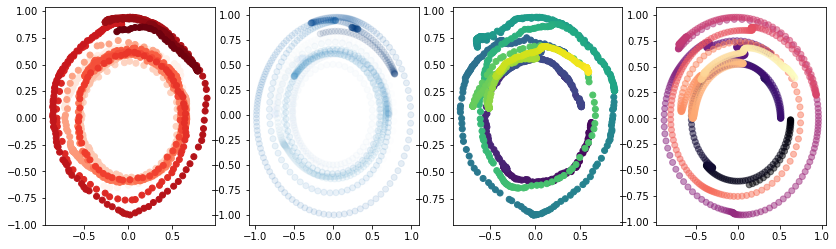

In [35]:
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(1,4,1)
ax.scatter(mean[:999, 0], mean[:999, 1], c=color, cmap="Reds")
ax = fig.add_subplot(1,4,2)
ax.scatter(y1[:,1]* np.cos(y1[::step,0]), y1[:,1]*np.sin(y1[::step,0]),c=colory1[::step], cmap="Blues", alpha=0.1)

ax = fig.add_subplot(1,4,3)
ax.scatter(mean[999:, 0], mean[999:, 1], c=colory1[:999], cmap="viridis")
ax = fig.add_subplot(1,4,4)
ax.scatter(y2[:,1]*np.cos(y2[::step,0]), y2[:,1]*np.sin(y2[::step,0]), cmap="magma", c=colory2[::step], alpha=.5)


To unclutter the presentation we plot the timecourse of the individual coordinates vs the timecourse of the predicted coordinates


In [99]:
########################################################
################## 1D vs. TIME PLOTS ###################
########################################################

fig, axs = plt.subplots(1, 3, dpi=200)
axs[0].plot(mean[:, 0], label='data')
#axs[0].plot(low_dim_man_1[:999,0], alpha=0.5, label='model')
axs[0].set_title("x-coordinate")
axs[0].set_xlabel("time")
axs[0].legend()

axs[1].plot(mean[:, 1])
#axs[1].plot(low_dim_man_1[:999,1], alpha=0.5)
axs[1].set_title("y-coordinate")
axs[1].set_xlabel("time")
axs[1].set_yticks([])


axs[2].plot(mean[:, 2])
#axs[2].plot(low_dim_man_1[:999,2], alpha=0.5)
axs[2].set_title("z-coordinate")
axs[2].set_xlabel("time")



Text(0.5, 0, 'time')

In [100]:
# ########################################################
# ########### 1D vs. TIME PLOTS - 2ND MANIFOLD ###########
# ########################################################

# fig, axs = plt.subplots(1, 3, dpi=200)
# axs[2].plot(mean[999:, 2])
# axs[2].plot(low_dim_man_2[:999,2], alpha=0.5)
# axs[2].set_title("z-coordinate")
# axs[2].set_xlabel("time")

# axs[1].plot(mean[999:, 1])
# axs[1].plot(low_dim_man_2[:999,1], alpha=0.5)
# axs[1].set_title("y-coordinate")
# axs[1].set_xlabel("time")
# axs[1].set_yticks([])


# axs[0].plot(mean[999:, 0])
# axs[0].plot(low_dim_man_2[:999,0], alpha=0.5)
# axs[0].set_title("x-coordinate")
# axs[0].set_xlabel("time")

In [101]:
from matplotlib import cm

In [41]:
x_prob = np.outer(r, np.cos(theta)).reshape(-1,1, order="F")
y_prob = np.outer(r, np.sin(theta)).reshape(-1,1, order="F")
z_prob = (np.stack([theta for i in range(100)])/np.pi).reshape(-1,1, order="F")

In [42]:
all_points = np.stack([x_prob, y_prob, z_prob],axis=1).squeeze()

In [43]:
single_tree = ppcabos.trees[12]

In [44]:
leaf_ids = single_tree.predict_leaf_id(all_points)

In [45]:
n_leaves = single_tree.leaf_counter

In [46]:
np.unique(leaf_ids, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58]),
 array([1107, 1002,  631,  872,  472,  453, 1917, 1482, 1097, 3902,  781,
         794,  803,  910, 1032, 1364, 1809,  505, 1574, 3562, 1143, 2586,
        1216, 1869, 1007,  459, 4169, 3929, 3826, 2816, 2987,  838, 2475,
        2502, 2730, 3095,  406,  859,  442, 4193, 3646, 1628, 3158,  284,
         181,  688,  332,  977,  537,  762,  972,  805, 3563,  370, 4005,
        1682, 1050, 3552, 2192]))

In [47]:
prob_color = cm.viridis(np.array(leaf_ids)/n_leaves)
prob_color = prob_color.reshape(100, 1000, 4, order="F")

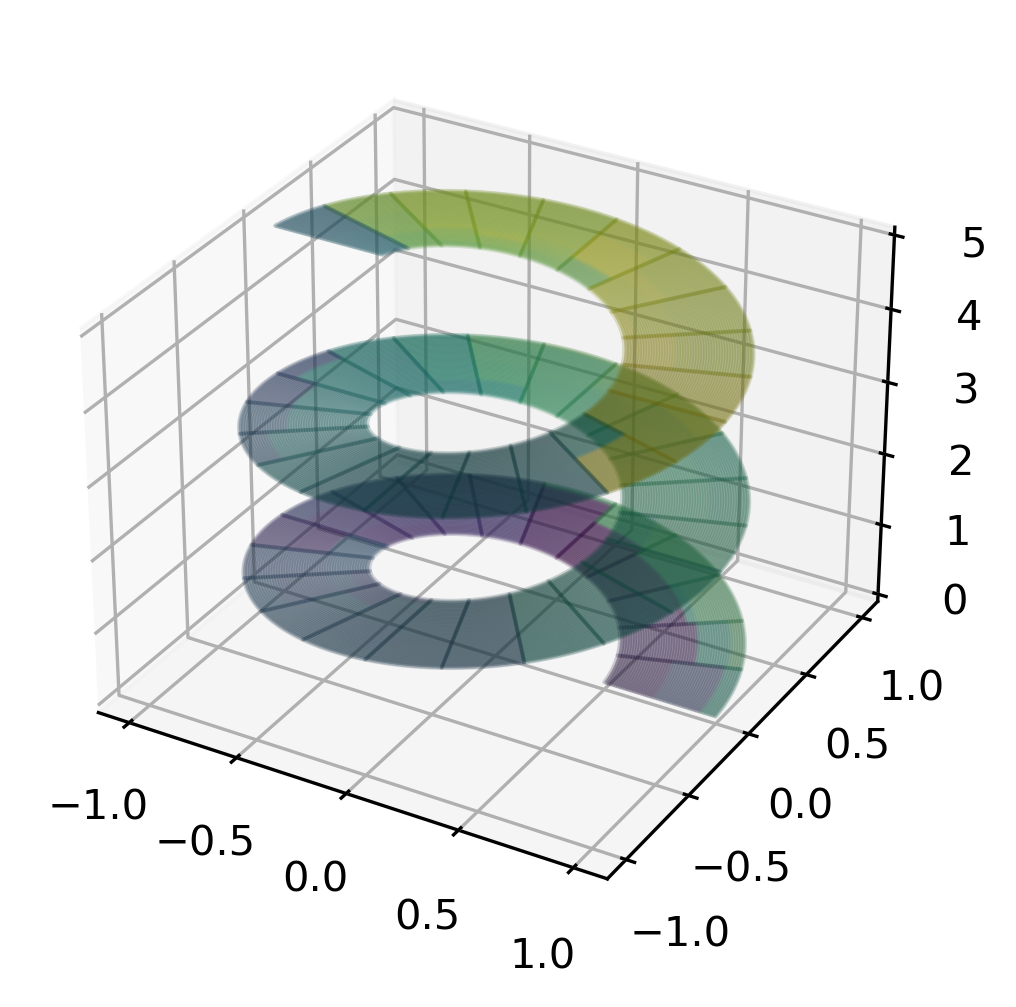

In [48]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,y,z, alpha=0.2, facecolors=prob_color)


In [30]:
data = np.fromfile('/home/cat/Downloads/All_ACF_functions_69x129.bin', dtype='float32')
print (data.shape)

(8901,)


In [31]:
data = data.reshape(129,-1)
print (data.shape)

(129, 69)


In [34]:
#######################
plt.plot(data.T)
plt.show()

In [ ]:
#######################

